# Quanutm Overflow

Overview:
1. Derive Carleman-linearized Lattice Boltzmann SWE equation for given number of grid points & dimensions
2. Encode the resulting CL-LBE matrix in a linear evolution using the forward Euler approximation
3. Encode the initial condition in the right hand side vector
4. Solve the system classically by means of matrix inversion
5. Extract the relevant data from the solution vector
6. Plot the results

### 1. Carleman linearisation and Lattice Boltzmann formalism

In [21]:
import numpy as np
import sys
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

class LBM_2_Carlemann1:
    def __init__(self, N_grid, h_init, u_init):
        # Constants for the D1Q3 lattice (1D, 3 velocities)
        self.w = np.array([2/3, 1/6, 1/6])  # Weights for D1Q3 lattice
        self.e = np.array([0, 1, -1])  # Lattice directions: [0, +1, -1]
        self.c_s = 1/np.sqrt(3)  # Speed of sound for D1Q3 lattice...is this the delta_x\delta_t ??
        self.kn = 0.1 #Knudsen number, much less than 1 for chapman-enskogg expansion

        # Parameters
        self.tau = 1.0  # Relaxation time
        self.nu = 0.08  # dissipation rate
        self.Nx = N_grid  # Number of grid points...my code for the F matrices makes the kernel die if this number is 81 or higher
        self.L = 0.001 # Length of the domain (in meters)
        #self.delta_t = self.L/self.Nx
        self.dx = self.L/self.Nx
        self.delta_t =  (self.dx*self.c_s**2)/np.sqrt(h_init[-1]*9.81)
        self.g = 9.81#*(self.delta_t**2/self.dx)  # Acceleration due to gravity (m/s^2)

        # Initialize macroscopic variables: density(height) and velocity field
        self.h = h_init  # height field
        self.u = u_init  # Velocity field

        # Initialize distribution functions (f_i), f has 3 directions (D1Q3)
        self.f = np.zeros((self.Nx, 3))  # Distribution functions for D1Q3
        self.feq = np.zeros_like(self.f)  # Equilibrium distribution functions

     #return a 1D array with one non-zero element of value 1 at specified index
    def one_nonzero(self,dim, n):
        array = np.zeros((dim))
        if n>-1 and n<dim:
            array[n] = 1
        return array
    #make the F matrices for the collision matrix for n grid points
    def gen_F(self):
        f1 = np.zeros((3,3))
        f1[0,1] = f1[0,2] = 1
        f1[1,1] = 1/(2*self.c_s) - 1
        f1[1,2] = -1/(2*self.c_s)
        f1[2,1] = -1/(2*self.c_s)
        f1[2,2] = 1/(2*self.c_s) -1
        f1 = (1/(self.tau*self.kn))*f1
        
        f2 = np.zeros((3,9))
        for i in range(9):
            f2[0,i] = -self.g
            f2[1,i]  = self.g
            f2[2,i]  = self.g
        f2[0,4] = f2[0,4] -4 
        f2[0,8] = f2[0,8] -4
        f2[0,5] = f2[0,5] +4 
        f2[0,7] = f2[0,7] +4
        for i in range(2):
            f2[i+1, 4] = f2[i+1, 4] +2
            f2[i+1, 8] = f2[i+1, 8] +2

            f2[i+1, 5] = f2[i+1, 5] -2
            f2[i+1, 7] = f2[i+1, 7] -2
        f2 = (1/(2*self.tau*self.kn*self.c_s**2))*f2

        f3 = np.zeros((3,9))
        f3[0,4] = 2
        f3[0,8] = 2
        f3[0,5] = -2 
        f3[0,7] = -2
        for i in range(2):
            f3[i+1, 4] = -1
            f3[i+1, 8] = -1

            f3[i+1, 5] = 1
            f3[i+1, 7] = 1
        f3 = np.hstack((f3,f3,f3))
        f3 = (1/(2*self.tau*self.kn*self.c_s**2))*f3

        #generalise to n grid points...strategy is to stack matrices, not create matrix of matrices I think...?
        n = self.Nx
        Q = len(self.e)
        '''
        F1 = np.zeros((dim,Q, dim*Q))
        F2 = np.zeros((dim,Q, (dim**2)*(Q**2)))
        F3 = np.zeros((dim,Q, (dim**3)*(Q**3)))
        '''
        I = self.one_nonzero(n, 0)
        F1 = np.kron(I, f1)
        F2 = np.kron(np.kron(I,I) , f2)
        F3 = np.kron(np.kron(np.kron(I, I), I), f3)


        for i in range(n-1):
            I = self.one_nonzero(n, i+1)
            F1 = np.vstack((F1, np.kron(I, f1)))
            F2 = np.vstack((F2, np.kron(np.kron(I,I) , f2)))
            F3 = np.vstack((F3, np.kron(np.kron(np.kron(I, I), I), f3)))
        
        return F1,F2,F3, f1, f2, f3
        
    #make A matrices for the collision matrix
    def gen_A(self, F1,F2,F3):
        A11 = F1
        A12 = F2
        A13 = F3
        Q= len(self.e)
        n = self.Nx
        dim = n*Q
        I = np.identity(dim)
        A22 = np.kron(F1,I) + np.kron(I, F1)
        #slows down at A22, kernel dies after with Nx = 50
        A23 = np.kron(F2,I) + np.kron(I, F2)
        A33 = np.kron(np.kron(F1,I), I) + np.kron(np.kron(I,F1), I) + np.kron(np.kron(I,I), F1)

        return A11, A12, A13, A22, A23, A33
    #make collision matrix 
    def gen_collision(self, A11, A12, A13, A22, A23, A33):
        C1 = np.vstack((A11,np.zeros((A22.shape[0]+A33.shape[0],A11.shape[1]))))
        C2 = np.vstack((A12,A22,np.zeros((A33.shape[0],A12.shape[1]))))
        C3 = np.vstack((A13, A23, A33))

        Cc = np.hstack((C1,C2,C3))

        return Cc
    
    #make streaming matrix, restricted to NN, 2nd order accuracy...only makes sense if we are considering more than 1 grid point
    def gen_streaming(self):
        Q= len(self.e)
        n = self.Nx
        inv_delta = n/(2*self.L)
        dim = n*Q
        I = np.identity(dim)
        S = np.zeros((dim, dim))

        main_diagonal = [1] * (self.Nx * len(self.e))
        #upper_diagonal = [-1] * ((self.Nx) * len(self.e)-3)
        lower_diagonal = [-1] * ((self.Nx) * len(self.e)-3)

        # Create the matrix
        S =  np.diag(main_diagonal, k=0)     # Main diagonal
        #S += np.diag(upper_diagonal, k=3)    # Upper diagonal 
        S += np.diag(lower_diagonal, k=-3)   # Lower diagonal 
       
        #add periodic BC
        S[0,-3]=S[1,-2]=S[2,-1]=-1
        #S[-3,0]=S[-2,1]=S[-1,2]=1
        
        #multiply with e_m
        S[::3, :] = 0 
        S[1::3, :] *= 1 
        S[2::3, :] *= -1 
           
        S = (inv_delta)* S
        #print(S)

        #alternative way to construct the matrix
        """        
        for i in range(dim):
            #deal with edge case here...periodic or bounce back BC...here I do code for periodic
            if i<Q:
                S[i,i+Q] = inv_delta*self.e[(i%3)]
                S[i, (dim-Q)+i] = -inv_delta*self.e[(i%3)]
            elif i>dim -Q - 1:
                S[i,dim-i] = inv_delta*self.e[(i%3)]
                S[i,i-Q] = -inv_delta*self.e[(i%3)]
            else:
                S[i,i+Q] = inv_delta*self.e[(i%3)]
                S[i,i-Q] = -inv_delta*self.e[(i%3)]
            """
        
        """ 
        #main_diagonal = [1] * (self.Nx * len(self.e))
        upper_diagonal = [-1] * ((self.Nx) * len(self.e)-3)
        lower_diagonal = [-1] * ((self.Nx) * len(self.e)-3)

        # Create the matrix
        #S =  np.diag(main_diagonal, k=0)     # Main diagonal
        S += np.diag(upper_diagonal, k=3)    # Upper diagonal 
        S += np.diag(lower_diagonal, k=-3)   # Lower diagonal 
       
        #add periodic BC
        S[0,-3]=S[1,-2]=S[2,-1]=-1
        S[-3,0]=S[-2,1]=S[-1,2]=1
        
        #multiply with e_m
        S[::3, :] = 0 
        S[1::3, :] *= 1 
        S[2::3, :] *= -1 

        S = (inv_delta)* S
        
        """
        
        B11 = S
        B22 = np.kron(S,I) + np.kron(I, S)
        B33 = np.kron(np.kron(S,I), I) + np.kron(np.kron(I,S), I) + np.kron(np.kron(I,I), S)

        C1 = np.vstack((B11,np.zeros((B22.shape[0]+B33.shape[0],B11.shape[1]))))
        C2 = np.vstack((np.zeros((B11.shape[0],B22.shape[1])),B22,np.zeros((B33.shape[0],B22.shape[1]))))
        C3 = np.vstack((np.zeros((B11.shape[0]+B22.shape[0],B33.shape[1])), B33))

        Cs = np.hstack((C1,C2,C3))

        return Cs, B11,B22,B33,S

### 2. Map the CL-LBE (ODE) to a LSE via the forward Euler approx.

In [22]:
def embed_matrix(C, delta_t, num_steps):
    """
    Embeds a matrix C into a larger matrix A with specified properties.

    Parameters:
        C (np.ndarray): The matrix to embed (must be square).
        delta_t (float): The length of each time step.
        num_steps (int): The number of time steps (and thus of cascaded blocks in A).

    Returns:
        np.ndarray: The constructed matrix A.
    """
    # Validate inputs
    if not (isinstance(C, np.ndarray) and C.ndim == 2 and C.shape[0] == C.shape[1]):
        raise ValueError("C must be a square matrix.")

    # Identity matrix with the same size as C
    Id = np.eye(C.shape[0])

    # Compute -O = -(Id + delta_t * C)
    O = -(Id + delta_t * C)

    # Size of the large matrix A
    A_size = num_steps * C.shape[0]

    # Initialize A as a zero matrix
    A = np.zeros((A_size, A_size))

    # Fill in the diagonal blocks
    for i in range(num_steps):
        # Main diagonal (Identity blocks)
        start_idx = i * C.shape[0]
        A[start_idx:start_idx + C.shape[0], start_idx:start_idx + C.shape[0]] = Id

        # Secondary diagonal (-O blocks)
        if i > 0:
            prev_idx = (i - 1) * C.shape[0]
            A[start_idx:start_idx + C.shape[0], prev_idx:prev_idx + C.shape[0]] = O

    return A

Generate the Matrix that in the paper is refeared as E, that correspond to Lin_Euler_Matrix

In [ ]:
N_grid = 4
h_init = [1,1,1,1]
u_init = [0,0,0,0]
N_time = 2  # Number of time steps

Gen = LBM_2_Carlemann1(N_grid, h_init, u_init )

F1,F2,F3, f1,f2,f3  = Gen.gen_F()

A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1,F2,F3)

Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
Cs, B11,B22,B33,S = Gen.gen_streaming()

CL_LBE_Matrix =  Cc+Cs

delta_t = Gen.delta_t
Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
print("Shape of the Matrix:", Lin_Euler_Matrix.shape)

cond_number = np.linalg.cond(Lin_Euler_Matrix)
print(f"The condition number of the matrix is: {cond_number}")

Shape of the Matrix to invert: (3768, 3768)
The condition number of the matrix is: 3.4503955171492007


Investigation on how the condition number scale with the number of timesteps

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [1:43:35<00:00, 1553.80s/it]  


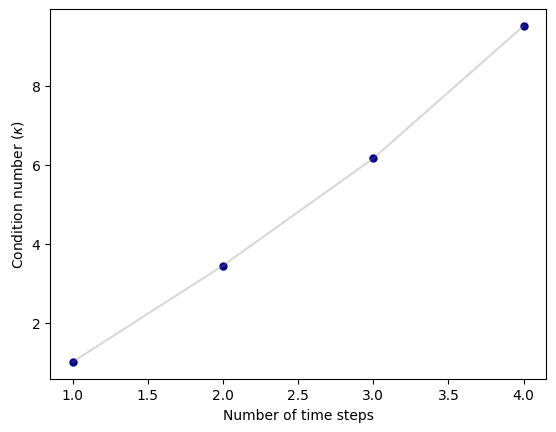

In [24]:
N_grid = 4
h_init = [1,1,1.01,1.01]
u_init = [0,0,0,0]

time_steps = range(1, 5)
condition_numbers = []

# Loop over different numbers of time steps
for N_time in tqdm(time_steps):
    Gen = LBM_2_Carlemann1(N_grid, h_init, u_init)
    F1, F2, F3, f1, f2, f3 = Gen.gen_F()
    A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1, F2, F3)
    Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
    Cs, B11, B22, B33, S = Gen.gen_streaming()
    CL_LBE_Matrix = Cc + Cs
    delta_t = Gen.delta_t
    Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
    
    # Calculate and store the condition number
    cond_number = np.linalg.cond(Lin_Euler_Matrix)
    condition_numbers.append(cond_number)

# Plot condition number vs. time steps
plt.figure()
plt.plot(time_steps, condition_numbers, linestyle='-', alpha=0.3, color='gray')
plt.scatter(time_steps, condition_numbers, s=25, color='darkblue')
plt.xlabel("Number of time steps")
plt.ylabel("Condition number ($\kappa$)")
plt.show()

Investigate sparsity of the generated matrix

Big Matrix:
[[5 9 2 8 7 7 0 9 5 3 6 7]
 [1 6 4 6 3 5 0 9 0 2 1 2]
 [9 6 2 2 4 7 3 9 8 8 7 7]
 [1 5 3 3 9 6 6 8 9 2 8 4]
 [6 0 2 4 0 0 7 8 6 7 9 3]
 [9 1 3 4 9 2 3 1 7 4 1 3]
 [2 3 1 9 9 3 9 7 1 4 1 4]
 [4 2 0 8 3 6 1 1 0 8 6 6]
 [2 6 6 6 9 1 8 5 8 4 8 3]
 [1 2 5 2 2 6 7 6 1 8 2 9]]

Submatrix 1 (Blue):
[[4 6 3]
 [2 2 4]]

Submatrix 2 (Red):
[[1 7 4]
 [7 1 4]
 [1 0 8]]

Submatrix 3 (Green):
[[3 1]
 [2 0]
 [6 6]]
Found 1 matches for submatrix 1
Found 1 matches for submatrix 2
Found 1 matches for submatrix 3


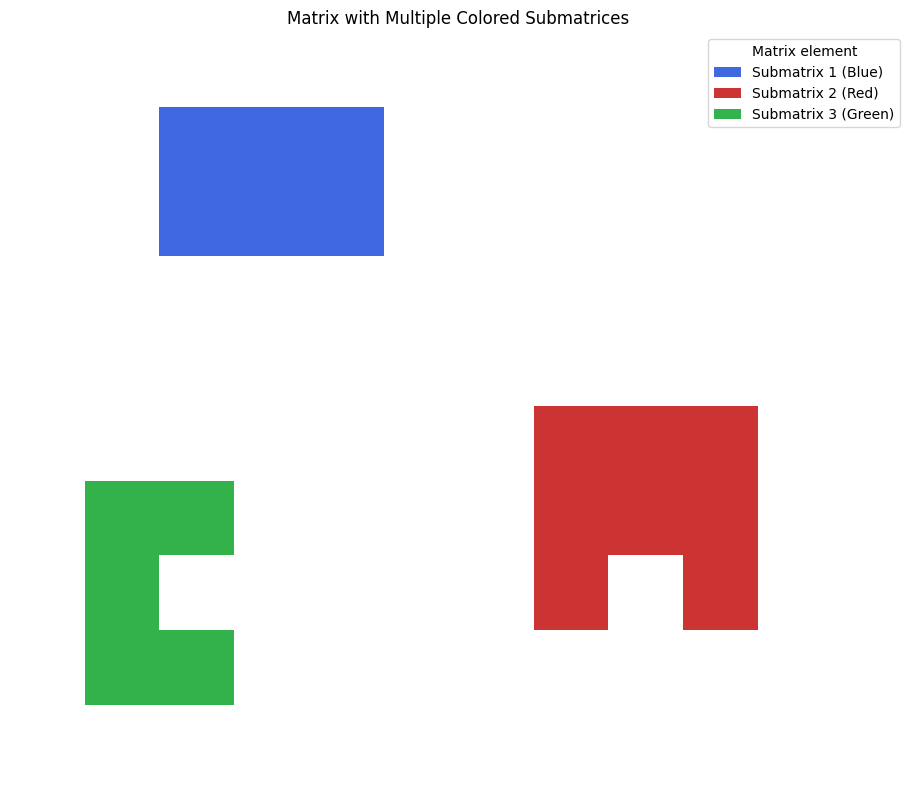


Visualization saved as 'multi_submatrix_visualization.png'


In [ ]:
from matplotlib.patches import Patch

def find_submatrix(big_matrix, sub_matrix):
    """
    Find all occurrences of sub_matrix in big_matrix.
    Returns a list of (row, col) tuples indicating the top-left corner of each match.
    """
    height, width = big_matrix.shape
    sub_height, sub_width = sub_matrix.shape
    
    matches = []
    
    # Check each possible starting position in the big matrix
    for i in range(height - sub_height + 1):
        for j in range(width - sub_width + 1):
            # Extract the potential match region
            region = big_matrix[i:i+sub_height, j:j+sub_width]
            
            # Compare with the submatrix
            if np.array_equal(region, sub_matrix):
                matches.append((i, j))
    
    return matches

def visualize_matrix_with_multiple_submatrices(big_matrix, submatrices_with_colors):
    """
    Visualize the big matrix with multiple submatrices in different colors
    
    Parameters:
    -----------
    big_matrix : numpy.ndarray
        The large matrix to search within
    submatrices_with_colors : list of tuples
        Each tuple contains (submatrix, color_name, color_rgb)
    """
    height, width = big_matrix.shape
    
    # Create a visualization array filled with white (1's)
    vis_array = np.ones((height, width, 3))
    
    # Create a list to store legend elements
    legend_elements = [Patch(facecolor='white', label='Matrix element')]
    
    # Process each submatrix and its designated color
    for sub_idx, (sub_matrix, color_name, color_rgb) in enumerate(submatrices_with_colors):
        # Find matches for this submatrix
        matches = find_submatrix(big_matrix, sub_matrix)
        print(f"Found {len(matches)} matches for submatrix {sub_idx+1}")
        
        # Skip if no matches found
        if not matches:
            continue
        
        # Create mask for this submatrix
        sub_height, sub_width = sub_matrix.shape
        mask = np.zeros((height, width), dtype=bool)
        
        # Mark positions of non-zero elements in this submatrix
        for i, j in matches:
            for si in range(sub_height):
                for sj in range(sub_width):
                    if sub_matrix[si, sj] != 0:  # Only mark non-zero elements
                        mask[i+si, j+sj] = True
        
        # Apply the color to masked cells
        for i in range(height):
            for j in range(width):
                if mask[i, j]:
                    vis_array[i, j] = color_rgb
        
        # Add to legend
        legend_elements.append(Patch(facecolor=color_rgb, label=f'Submatrix {sub_idx+1} ({color_name})'))
    
    # Create the figure
    plt.figure(figsize=(10, 8))
    
    # Display the image without axes or grid
    plt.imshow(vis_array)
    plt.axis('off')
    
    # Add the legend
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title('Matrix with Multiple Colored Submatrices')
    plt.tight_layout()
    plt.savefig('multi_submatrix_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()


# Create a random big matrix
big_matrix = np.random.randint(0, 10, size=(10, 12))
    
    # Define several submatrices with their colors
    # Format: (submatrix, color_name, color_rgb)
submatrices_with_colors = [
        # First submatrix - blue
        (big_matrix[1:3, 2:5].copy(), 'Blue', np.array([0.25, 0.41, 0.88])),
        
        # Second submatrix - red
        (big_matrix[5:8, 7:10].copy(), 'Red', np.array([0.8, 0.2, 0.2])),
        
        # Third submatrix - green
        (big_matrix[6:9, 1:3].copy(), 'Green', np.array([0.2, 0.7, 0.3])),
        
        # You can add more submatrices with different colors
]
    
    # Display the matrices
print("Big Matrix:")
print(big_matrix)
    
for i, (submatrix, color_name, _) in enumerate(submatrices_with_colors):
    print(f"\nSubmatrix {i+1} ({color_name}):")
    print(submatrix)
    
    # Visualize with multiple colors
visualize_matrix_with_multiple_submatrices(big_matrix, submatrices_with_colors)
    
print("\nVisualization saved as 'multi_submatrix_visualization.png'")


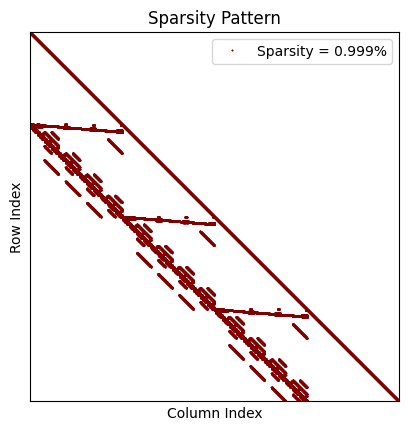

In [34]:
# Calculate sparsity
matrix = Lin_Euler_Matrix
total_elements = matrix.size
nonzero_elements = np.count_nonzero(matrix)
zero_elements = total_elements - nonzero_elements
sparsity = zero_elements / total_elements

plt.figure()
plt.spy(matrix, markersize=0.5, color='maroon', label=f'Sparsity = {np.round(sparsity, 4)}%')

plt.title("Sparsity Pattern")
plt.xlabel("Column Index")
plt.ylabel("Row Index")

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [43]:
visualize_matrix_with_multiple_submatrices(Lin_Euler_Matrix, [(CL_LBE_Matrix,"Blue", CL_LBE_Matrix)])

KeyboardInterrupt: 

### 3. Encode the initial condition in the rigth hand side vector phi

In [26]:
def initial_distribution(Nx,h,u):

    distr = np.zeros((Nx,3))

    for g in range (Nx):
        for i in range(3):
            if i==0:
                distr[g,i]= h[g]*(1/6 - u[g]/2)
            if i==1:
                distr[g,i]= h[g]*2/3
            if i==2:
                distr[g,i]= h[g]*(1/6 + u[g]/2)
            
    initial_distribution = np.hstack([distr[g,:] for g in range (Gen.Nx)])  # Function of 3 values in the 1D case
    
    return initial_distribution


def append_zeros(f, N):
    # Ensure `f` is a NumPy array
    f = np.array(f)

    # Create N zero vectors of the same shape as `f`
    zero_vector = np.zeros_like(f)
    zeros_to_append = np.tile(zero_vector, (N-1,))

    # Concatenate `f` with the appended zeros
    result = np.concatenate([f, zeros_to_append])

    return result

f1 = initial_distribution(Gen.Nx, Gen.h, Gen.u)
f2 = np.kron(f1,f1)
f3 = np.kron(f2,f1)

phi_t0 = np.hstack((f1,f2,f3))

phi = append_zeros(phi_t0, N_time)

### 4. Solve LSE classically

In [28]:
Inverted_matrix = np.linalg.inv(Lin_Euler_Matrix)
x = np.dot(Inverted_matrix, phi)

### 5. Extract the relevant information from the resulting vector

In [ ]:
def extract_phi(x, subvector_dim, N):
    if len(x) < N * subvector_dim:
        raise ValueError("The length of x is too small for the given N and subvector_dim.") 
    # Extract phi components
    phi = [x[i * subvector_dim : (i + 1) * subvector_dim] for i in range(N)]
    return phi

def phi_truncation(phi_list, N):
    num_values = 3 * N
    truncated_phi = [phi[:num_values] for phi in phi_list]
    return truncated_phi

def divide_truncated_phi(truncated_phi, N):
    result = []
    for phi in truncated_phi:
        # Ensure the truncated phi has at least 3 * N elements
        if len(phi) < 3 * N:
            raise ValueError("Each truncated phi must have at least 3 * N elements.")
        
        # Divide phi into N groups of 3
        groups = [phi[3 * i : 3 * (i + 1)] for i in range(N)]
        result.extend(groups)
    
    return result

In [29]:
N_grid = Gen.Nx

grid_evolution = np.zeros((N_grid,N_time,3))

subvector_dim = 3 * N_grid + 9 * N_grid**2 + 27 * N_grid**3
print("Subvector dimension:", subvector_dim)

# Extract phi components for each time step
phi = extract_phi(x, subvector_dim, N_time)

# Extract the first 3 * N values from each phi_i
truncated_phi = phi_truncation(phi, N_grid)

# Divide each truncated phi into N groups of 3 and combine them
three_dim_vectors = divide_truncated_phi(truncated_phi, N_grid)

# Display the results
for i, vec in enumerate(three_dim_vectors, start=0):
    #print(f"Grid {i % Gen.Nx} at time { i // Gen.Nx}: {vec}")
    grid_evolution[i % Gen.Nx, i // Gen.Nx,:] = vec




Subvector dimension: 1884


In [30]:
np.save('Lin_Euler_Matrix.npy', Lin_Euler_Matrix)
np.save('phi.npy', phi)
np.save('x.npy', x)

### 6. Plot the resulting heigths and Errors at every timestep

Timestep 0
Grid 0 height: 0.9999999999999998
Grid 1 height: 0.9999999999999998
Grid 2 height: 1.0100000000000002
Grid 3 height: 1.0099999999999998

Timestep 1
Grid 0 height: 1.0016895928556708
Grid 1 height: 1.0058500202634093
Grid 2 height: 1.0162191670582623
Grid 3 height: 1.0119804363826248

Timestep 2
Grid 0 height: 1.003344390803062
Grid 1 height: 1.0117672185776765
Grid 2 height: 1.022558126735785
Grid 3 height: 1.0139681365658428

Timestep 3
Grid 0 height: 1.004987405345304
Grid 1 height: 1.0177768969689442
Grid 2 height: 1.0289965140622443
Grid 3 height: 1.015939666462417

Error total
Timestep 0 Error_tot= 0.0
Timestep 1 Error_tot= 0.0038949093879031386
Timestep 2 Error_tot= 0.007789541434820177
Timestep 3 Error_tot= 0.011684183070594262

Error per timestep
Timestep 0 Error_per_timestep= 0.011863397490607061
Timestep 1 Error_per_timestep= 0.0038949093879031386
Timestep 2 Error_per_timestep= 0.003914274653677868
Timestep 3 Error_per_timestep= 0.003934281644138863

Total_water
Ti

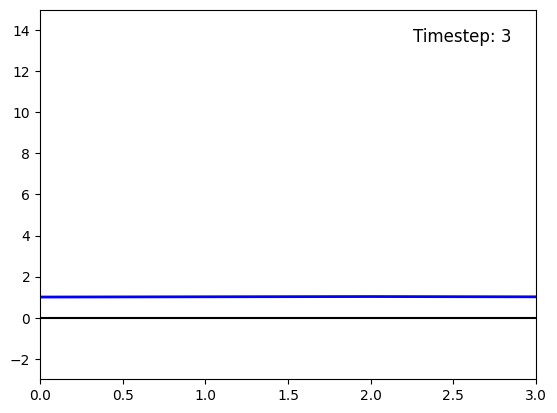

In [ ]:
#heigth
h = np.zeros((N_grid,N_time))
Error_tot = np.zeros((N_time))
Error_per_timestep = np.zeros((N_time))
Water_tot = np.zeros((N_time))

for t in range (N_time):
    print("Timestep", t)
    for g in range (N_grid):
        h[g, t] = sum(grid_evolution[g,t,:])
        print(f"Grid {g} height: {h[g,t]}")
    print("")

print("Error total")
for t in range (N_time):
    for g in range (N_grid):
        h[g, t] = sum(grid_evolution[g,t,:])
    Error_tot[t] = sum(abs((h[:,t]-h[:,0])/h[:,t]))/N_grid
    print("Timestep", t,"Error_tot=", Error_tot[t])
print("")

print("Error per timestep")
for t in range (N_time):
    for g in range (N_grid):
        h[g, t] = sum(grid_evolution[g,t,:])
    Error_per_timestep[t] = sum(abs((h[:,t]-h[:,t-1])/h[:,t]))/N_grid
    print("Timestep", t,"Error_per_timestep=", Error_per_timestep[t])
print("")

print("Total_water")
for t in range (N_time):
    for g in range (N_grid):
        h[g, t] = sum(grid_evolution[g,t,:])
    Water_tot[t] = sum((h[:,t]))
    print("Timestep", t,"Water_tot=", Water_tot[t])
print("")

"""
for t in range (N_time):
    print("Timestep", t)
    for g in range (N_grid):
        u[g, t] = sum(Gen.e*grid_evolution[g,t,:])/h[g,t]
        print(f"Grid {g} velocity: {u[g,t]}")
    print("")
    
"""

# Example 2D array of heights: rows are timesteps (t), columns are grid points (g)
timesteps = N_time
grid_points = Gen.Nx

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim([0, grid_points - 1])  # Set x-axis limits to the number of grid points
ax.set_ylim(-3, 15)  # Adjust the y-axis to fit the height data
# Add a placeholder for the timestep text
timestep_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', va='top', fontsize=12)
ax.axhline(y=0, color='black', linestyle='-')  # Adds a horizontal dashed line at y=0


# Initialize the line object (empty initially)
line, = ax.plot([], [], lw=2, color='blue')  # Line object to plot the profile
x = np.arange(grid_points)  # x values represent the grid points (g)

# Animation function: updates the line plot with heights at each timestep
def animate(t):
    y = h[:, t]  # Heights at all grid points for timestep t
    line.set_data(x, y)  # Set the x and y data for the line plot
    timestep_text.set_text(f'Timestep: {t}')  # Display current timestep
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, animate, repeat=True, frames=timesteps, interval=10000)
writer = animation.PillowWriter(fps=0.5)
ani.save('height_profile.gif', writer=writer)
plt.show()


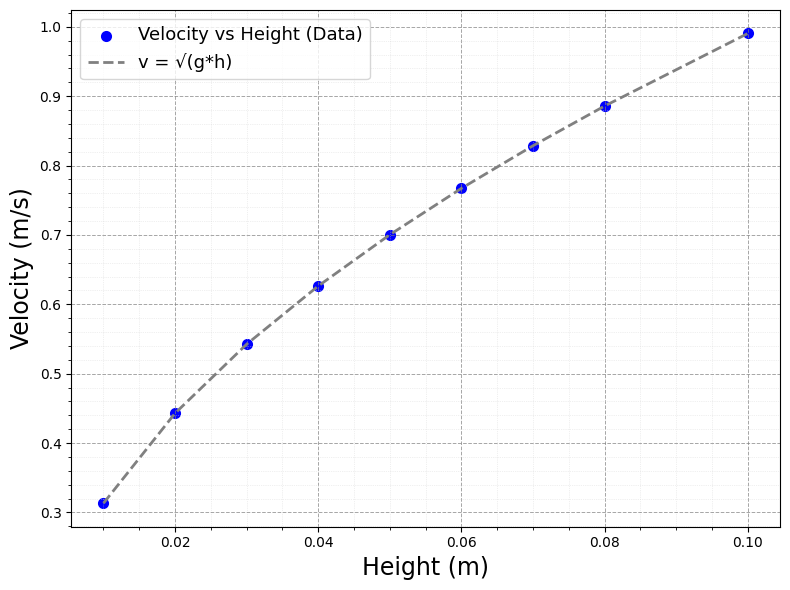

In [32]:
heights = np.array([ 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,0.08, 0.10])  # Heights ranging from 0 to 100
n_timesteps = [ 4, 4, 4, 4, 4,4, 4, 4, 4]  # velocity data taken as described in the paper
dt =  (Gen.dx*Gen.c_s**2)/np.sqrt(heights*9.81)
vel = Gen.dx/(n_timesteps*dt)*4/3
background_velocities = np.sqrt(Gen.g * heights) 

# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size
plt.scatter(heights,vel, label="Velocity vs Height (Data)", color="blue", lw=2)
plt.plot(heights, background_velocities, label="v = √(g*h)", color="grey", linestyle="--", lw=2)

# Customize the grid
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.7, alpha=0.7)  # Major gridlines
plt.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.7)  # Minor gridlines

# Add labels and legend
plt.xlabel("Height (m)", fontsize=17)
plt.ylabel("Velocity (m/s)", fontsize=17)
plt.legend(fontsize=13)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


Text(0, 0.5, 'Relative Error')

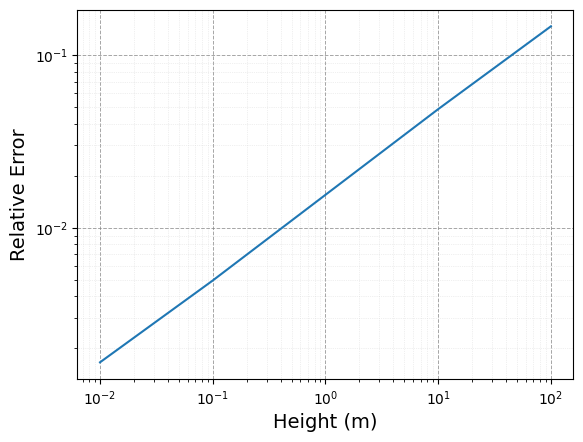

In [33]:
heights = np.array([ 0.01, 0.1, 1, 10, 100])  # Heights ranging from 0 to 100
Error = [ 0.00166, 0.004943, 0.0155, 0.0486, 0.14666819659741942] # Relative error after 1 timestep at different initial heigths

plt.loglog(heights, Error)

# Customize the grid
plt.grid(which='major', color='gray', linestyle='--', linewidth=0.7, alpha=0.7)  # Major gridlines
plt.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.7)  # Minor gridlines

# Add labels and legend
plt.xlabel("Height (m)", fontsize=14)
plt.ylabel("Relative Error", fontsize=14)